# Python 使用 nibabel库 查看三维数据(nii.gz格式)的各种图像参数

>编程环境：jupyter notebook

## 导入所有安装包

In [1]:
import numpy as np
import nibabel as nib
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
# 魔法函数
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

## 读取图像 提取numpy数组

In [2]:
# 使用 nibabel 库 读取图像
image_path ="C:\\Users\\14137\\Desktop\\sci\\kechuang\\CM-CH\\images\\002.nii.gz"
image_obj = nib.load(image_path)
print(f'Type of the image {type(image_obj)}')

# 使用 get_fdata()方法从 image_obj中提取 data
image_data = image_obj.get_fdata()
type(image_data)

Type of the image <class 'nibabel.nifti1.Nifti1Image'>


numpy.ndarray

## 查看图像参数

In [6]:
# 查看图像大小
height, width, depth = image_data.shape
print(f"The image object height: {height}, width:{width}, depth:{depth}")


The image object height: 512, width:512, depth:24


In [7]:
# 查看图像值范围
print(f'image value range: [{image_data.min()}, {image_data.max()}]')

image value range: [-1024.0, 1808.0]


In [8]:
# 查看图像成像信息 如 层厚，平面（in-plane）分辨率等
print('图像成像信息:')
print(image_obj.header.keys())

图像成像信息:
['sizeof_hdr', 'data_type', 'db_name', 'extents', 'session_error', 'regular', 'dim_info', 'dim', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'pixdim', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'slice_code', 'xyzt_units', 'cal_max', 'cal_min', 'slice_duration', 'toffset', 'glmax', 'glmin', 'descrip', 'aux_file', 'qform_code', 'sform_code', 'quatern_b', 'quatern_c', 'quatern_d', 'qoffset_x', 'qoffset_y', 'qoffset_z', 'srow_x', 'srow_y', 'srow_z', 'intent_name', 'magic']


关键字段含义如下：

sizeof_hdr sizeof_hdr 是保存文件的头文件大小，如果是NIFTI-1或者ANALYZE格式的文件sizeof_hdr=348.
dim_info：dim_info字段存储着频率编码方向（1,2,3），相位编码方向（1,2,3）和采集期间层选择方向（1,2,3），对于径向采集来讲，频率编码和相位编码都设置为0。

dim：short dim[8]保存着前面提到的图像的维度信息。如果第0维不是（1-7）之间的数字，那么这个数据具有相反的字节顺序，所以应该进行字节交换（NIFTI标准没有提供字节顺序的字段，提倡使用dim[0]）。

datatype中存储的是数据的类型。
bitpix字段必须与datatype中的代码所对应的bit(s)/pix的大小相等。

slice切片信息
包含字段：slice_start，slice_end, slice_code, slice_duration
slice_duration是存储功能磁共振成像采集的时间相关信息，需要与dim_info字段一起使用。

pixdim体素维度：每个体素维度信息都保存在pixdim中，各自对应dim，但pixdim[0]有特殊意义，其值只能是-1或1。前四个维度将在xyzt_units字段中指定。pixdim[1]对应x轴，pixdim[2]对应y轴,pixdim[3]对应z轴

vox_offset体素偏移量：vox_offset指 单个文件（.nii）图像数据的字节偏移量。

In [9]:
# 其中，最感兴趣的是图像的分辨率 在 pixdim 里面 单位mm
pixdim =  image_obj.header['pixdim']
print(f'z轴分辨率： {pixdim[3]}')
print(f'in plane 分辨率： {pixdim[1]} * {pixdim[2]}')

z轴分辨率： 5.269999980926514
in plane 分辨率： 0.4882810115814209 * 0.4882812201976776


In [10]:
# 我们知道层厚信息，以及矩阵大小，就可以求出实际的扫描范围。
# 比如我们要知道z轴方向实际扫了多少mm, 用z轴方向的分辨率 * 矩阵大小
# 对于 nii.gz 类型的三维图像，分辨率通常指的是在三个维度（x、y、z）上的像素数量。
# 每个体素（Voxel）代表了图像中的一个三维像素点，分辨率确定了图像的空间细节程度和体积大小。
z_range = pixdim[3] * depth
x_range = pixdim[1] * height
y_range = pixdim[2] * width
print(x_range, y_range, z_range)

249.9998779296875 249.99998474121094 126.47999954223633


## 可视化图像
大家都知道，python是没法直接显示三维图像的，如果非常想要看一下图像什么样，可以一层一层的显示。

Plotting z Layer 21 of Image


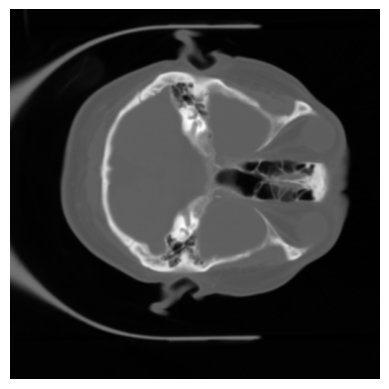

In [13]:
# 1. 随机单独显示某一层
maxval = 24
i = np.random.randint(0, maxval)
# Define a channel to look at
print(f"Plotting z Layer {i} of Image")
plt.imshow(image_data[:, :, i], cmap='gray')
plt.axis('off');

In [14]:
# 2.交互显示 
# 所谓交互显示，实际也是显示某一层，只不过可以通过鼠标拉动，依次显示每一层图像
def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(image_data[:, :, layer], cmap='gray');
    plt.title('Explore Layers of adrenal', fontsize=20)
    plt.axis('off')
    return layer

interact(explore_3dimage, layer=(0, image_data.shape[-1]));


interactive(children=(IntSlider(value=12, description='layer', max=24), Output()), _dom_classes=('widget-inter…

## 获取 label 信息

In [19]:
# 像读取图像一样读取数据
label_path = "C:\\Users\\14137\\Desktop\\sci\\kechuang\\CM-CH\\masks\\002.nii.gz"
label_obj = nib.load(label_path)
label_array = label_obj.get_fdata()
type(label_array)

numpy.ndarray

In [20]:
# 查看 label 里面有几种值 使用 np.unique()
print(f'With the unique values: {np.unique(label_array)}')

With the unique values: [0. 1.]


In [22]:
# 更进一步，查看每个标签对应多少像素
# 返回独一无二的标签，以及对应的像素数量
np.unique(label_array, return_counts=True)

(array([0., 1.]), array([6291052,     404], dtype=int64))

在深度学习中，"images" 指的是输入模型的图像数据，通常是需要被处理、分析或识别的图像。这些图像可以是 RGB 图像（红绿蓝通道），灰度图像，或者其他形式的图像数据。

而 "masks" 则通常用于语义分割（semantic segmentation）等任务中，代表了每个像素所属的类别或区域。每个像素对应的 mask 值指示该像素属于特定类别的概率或类别标识符。通过比较输入图像和相应的 mask，模型可以学习图像中不同区域的语义信息，进行像素级别的分类或分割。